In [262]:
import pandas as pd
import numpy as np
import math
import time
from scipy.optimize import minimize
import astropy.constants as const
import rebound

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':20})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

G = 6.674e-8

In [288]:
# Stellar parameters
mstar = .32 
         
# Planet parameters
N = 4
P = np.array([61.1166, 30.0881, 1.937780, 124.26])
a = np.array([0.208317, 0.129590, 0.02080665, 0.3343])
e = np.array([0.0324, 0.25591, 0.207, 0.055])
m = np.array([2.2756, 0.7142, 0.021, 0.046]) * const.M_jup.value / const.M_sun.value
w = np.array([234, 48.76, 50.3, 239]) * math.pi/180
M = np.array([355, 294.59, 325.7, 335]) * math.pi/180
K = np.array([6.56, 88.34, 214.00, 3.42])
i = 59
names = ['*', 'b', 'c', 'd', 'e']
colors = ['k', 'b', 'g', 'r', 'm']

def inclination_mass(inc, mp):
    return mp * np.sin(i)/np.sin(inc)

In [352]:
t0 = time.time()
sim = rebound.Simulation()
sim.units = ('days','AU','Msun')
sim.integrator = "whfast"
sim.dt = 1e-3

inc_d = 26
inc = inc_d * math.pi/180

sim.add(m=mstar)
for k in range(N):
    sim.add(m=inclination_mass(inc, m[k]), e=e[k], a=a[k], omega=w[k], M=M[k], inc=inc) 
sim.move_to_com()

torb = P[3]
Norb = 1000
Noutputs = 1000
times = np.linspace(0, Norb*torb, Noutputs)

x_sim  = np.zeros([Noutputs, N+1])
y_sim  = np.zeros([Noutputs, N+1])
vz_sim = np.zeros([Noutputs, N+1])
a_sim  = np.zeros([Noutputs, N+1])
w_sim  = np.zeros([Noutputs, N+1])
e_sim  = np.zeros([Noutputs, N+1])

for j,t_int in enumerate(times):
    sim.integrate(t_int, exact_finish_time=0)
    for k in range(0,N+1):
        x_sim[j,k]  = sim.particles[k].x
        y_sim[j,k]  = sim.particles[k].y
        vz_sim[j,k] = sim.particles[k].vz
        if k >= 1:
            a_sim[j,k] = sim.particles[k].a
            w_sim[j,k] = sim.particles[k].omega
            e_sim[j,k] = sim.particles[k].e
            
print(time.time() - t0)

144.09717345237732


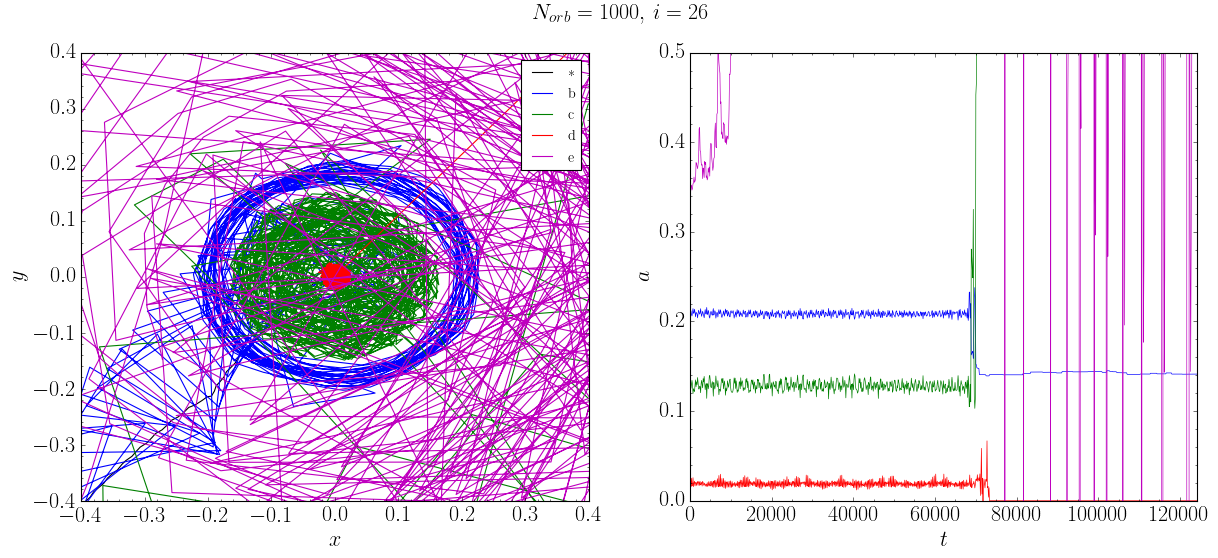

In [353]:
fig, ax = plt.subplots(1, 2, figsize=[18,7])
for k in np.arange(0,N+1):
    ax[0].plot(x_sim.T[k], y_sim.T[k], label=f'{names[k]}', color=colors[k])
ax[0].legend(loc=1, fontsize=13)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
ax[0].set_xlim([-.4,.4])
ax[0].set_ylim([-.4,.4])
ax[0].minorticks_on()

for k in range(1,5):
    ax[1].plot(times, a_sim.T[k], linewidth=.6, color=colors[k])
ax[1].set_xlim(0, max(times))
ax[1].set_ylim(0,.5)
ax[1].set_ylabel(r'$a$')
ax[1].set_xlabel(r'$t$')
ax[1].minorticks_on()
plt.suptitle(r'$N_{orb}=%s,\, i=%s$'%(Norb, inc_d))
plt.savefig(f'plots/N{Norb}_i{inc_d}_sim.png')
plt.show()